<a href="https://colab.research.google.com/github/ShawnTayNWU/MSDS458/blob/MSDS458/MSDS458_Assignment_03_ExpC_BiDir_NoEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 3

### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

## Import packages 

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from timeit import default_timer as timer #import a timer
from datetime import datetime

In [2]:
#tf.get_logger().setLevel('INFO')

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.6.0


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.6.0


### Functions For Research Assignment 

In [6]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 

In [7]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [8]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Mount Google Drive to Colab Environment

In [9]:
#from google.colab import drive
#drive.mount('/content/gdrive')

###  TensorFlow Datasets Information<br>
<div class="alert alert-block alert-info">
    <b> ag_news_subset</b><br>
    See https://www.tensorflow.org/datasets/catalog/ag_news_subset
    </div>

Get all the words in the documents (as well as the number of words in each document) by using the encoder to get the indices associated with each token and then translating the indices to tokens. But first we need to get the "unpadded" new articles so that we can get their length.

In [10]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2021-11-05 16:54:10.237969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 16:54:10.481117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 16:54:10.482240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I1105 16:54:10.483358 140250940995456 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
2021-11-05 16:54:10.492759: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-11-05 16

###  Exploratory Analysis AG News Subset

**Get information about the ag_news_subset dataset. We combined the training and test data for a total of 127,600 news articles.**

In [11]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [12]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


### Review Labels (Categories) 

In [13]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [14]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

The 127,600 news articles are evenly distributed among the 4 categories

In [15]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

### Preprocessing Data Create Input Pipeline

In [16]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2021-11-05 16:55:37.144508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 16:55:37.154268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 16:55:37.155222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I1105 16:55:37.156286 140128418367360 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I1105 16:55:37.157162 140128418367360 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I1105 16:55:37.158394 140128418367360 download_and_prepare.py:138] download_and_prep

In [17]:
####  Dataset Splits (Training, Test, Validation)
#### .8934 Training, .0470 Test, .0596 Validation

In [18]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset) 

(114000, 6000, 7600)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [19]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

Review Example with Interger Label(text, label pairs):

Review Example with Interger Label Encoded Classification(text, label pairs):

In [20]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [21]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [22]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Strong growth in UK customer numbers at MMO2 has enabled the mobile operator to raise its UK revenue growth forecast. In a trading update, MMO2 said it now expected UK revenue to grow by 9-12 in the year '
 b'Controversy has erupted in the open-source world over a report from the Gartner Group that predicts the vast majority of personal computers sold in Asia, Latin America and Eastern Europe that '
 b'Chris Bosh had 23 points and 11 rebounds to lead the Toronto Raptors to an 86-83 preseason win over Benetton Treviso on Wednesday night.']

labels:  [2 3 1]
texts:  [b'Despite a strong profit outlook from Ford Motor Co., shares of automotive stocks moved mostly lower Friday on concerns sales for the industry might not be as strong as previously expected.'
 b'Argentina #39;s David Nalbandian booked his place in the final of the Swiss Open for the third successive year on Saturday. The fourth-seed saw off Olympic gold medal winner Nicolas Massu of Chile 6-3 6-4 in the semi-final

In [24]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b'Holtz replaces John Thompson, who was forced out about two weeks ago after a 3-and-20 record in two seasons with the Pirates. Holtz has spent six years as assistant head coach and quarterbacks coach at South '
 b'Toys  quot;R quot; Us Inc. swung to a profit in the second quarter from a loss a year ago, buoyed by a reversal of \\$200 million in income tax reserves.'
 b" BEIJING (Reuters) - China sought Friday to soothe concerns  over a surprise interest rate rise, its first in nearly a  decade and one which is expected to kick off a series of  increases to cool growth in the world's seventh-biggest  economy."]

labels:  ['Sports', 'Business', 'Business']

texts:  [b"For Simon, a sidewalk mime from Trinidad who does his statue act in various Midtown locations, the difficulty isn't standing for ten hours at a time. It's getting off the stage."
 b'Once harvested almost to extinction in the northeastern U.S., beavers have returned in such huge numbers that they are becoming a nui

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [25]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [26]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

In [27]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

Here are the 20 least frequent words.

In [28]:
vocab[-20:]

array(['black', 'turn', 'build', 'countrys', 'advanced', 'whose',
       'crisis', 'create', '23', 'sources', 'body', 'militant', 'hope',
       'event', 'started', 'ready', 'jones', 'lawsuit', 'focus',
       'singapore'], dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [29]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  9,   1,   3,   1,   1,  23,   1,  59, 962,  24,   1,   1,   6,
          1,   1,   1,   2,   1,   1,   1,   9,   1, 649,  15,   3,  86,
         13, 796, 106,   2,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [672,   1, 547,   4,   1,   6,   2,   1,  25,   1,  30,   1,   6,
        396,   1,   1,  10,  53,  33,   1,   3,   1,   6,  99,   1,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  1,  28,   1,   1, 387, 718,   6,   3,   1, 446,  12, 312, 148,
         97,   1,   1,   8,  73,   4,   1, 213,   4, 116,  32,   1,   4,
        376,  24, 865, 375,   1,   4,   3, 144,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [30]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"For Simon, a sidewalk mime from Trinidad who does his statue act in various Midtown locations, the difficulty isn't standing for ten hours at a time. It's getting off the stage."
Round-trip:  for [UNK] a [UNK] [UNK] from [UNK] who does his [UNK] [UNK] in [UNK] [UNK] [UNK] the [UNK] [UNK] [UNK] for [UNK] hours at a time its getting off the [UNK]                        

Original:  b'Once harvested almost to extinction in the northeastern U.S., beavers have returned in such huge numbers that they are becoming a nuisance in some areas.'
Round-trip:  once [UNK] almost to [UNK] in the [UNK] us [UNK] have [UNK] in such [UNK] [UNK] that they are [UNK] a [UNK] in some [UNK]                              

Original:  b' JERUSALEM (Reuters) - Jewish settler leaders failed in a  rare meeting with Israeli Prime Minister Ariel Sharon on Sunday  to persuade him to back their proposal to put his planned Gaza  withdrawal to a national referendum.'
Round-trip:  [UNK] reuters [UNK] [UNK] lea

## Create the model: Single Layer Bidirectional RNN with LTSM (Experiment C1B)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [31]:
from keras import backend as K
K.clear_session()

num_classes = 4
model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model: Single Layer Bidirectional RNN with LTSM (Experiment C1B)

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [33]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


## Train the model: Single Layer Bidirectional RNN with LTSM (Experiment C1B)

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [34]:
start=datetime.now()

history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end=datetime.now()
print("Experiment C1B time:", end-start) 

Epoch 1/200
1782/1782 [==============================] - 47s 20ms/step - loss: 0.7771 - accuracy: 0.6914 - val_loss: 0.4956 - val_accuracy: 0.8290
Epoch 2/200
1782/1782 [==============================] - 33s 18ms/step - loss: 0.4527 - accuracy: 0.8407 - val_loss: 0.4261 - val_accuracy: 0.8498
Epoch 3/200
1782/1782 [==============================] - 33s 18ms/step - loss: 0.4129 - accuracy: 0.8521 - val_loss: 0.4016 - val_accuracy: 0.8583
Epoch 4/200
1782/1782 [==============================] - 33s 18ms/step - loss: 0.3976 - accuracy: 0.8569 - val_loss: 0.3954 - val_accuracy: 0.8612
Epoch 5/200
1782/1782 [==============================] - 32s 18ms/step - loss: 0.3894 - accuracy: 0.8596 - val_loss: 0.3916 - val_accuracy: 0.8600
Epoch 6/200
1782/1782 [==============================] - 33s 18ms/step - loss: 0.3836 - accuracy: 0.8613 - val_loss: 0.3866 - val_accuracy: 0.8598
Experiment C1B time: 0:03:30.989835


In [35]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 10ms/step - loss: 0.4048 - accuracy: 0.8522
Test Loss: 0.40478959679603577
Test Accuracy: 0.8522368669509888


## Plotting Performance Metrics - Single Layer Bidirectional RNN: Single Layer Bidirectional RNN with LTSM (Experiment C1B)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.777,0.691,0.496,0.829
1,0.453,0.841,0.426,0.850
2,0.413,0.852,0.402,0.858
3,0.398,0.857,0.395,0.861
4,0.389,0.860,0.392,0.860
5,0.384,0.861,0.387,0.860


In [38]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

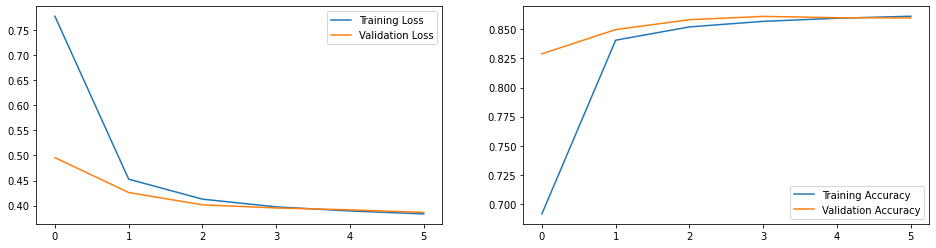

In [39]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Architecture Summary Single Layer Bidirectional RNN: Single Layer Bidirectional RNN with LTSM (Experiment C1B)

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 138,564
Trainable params: 138,564
Non-trainable params: 0
_________________________________________________________________


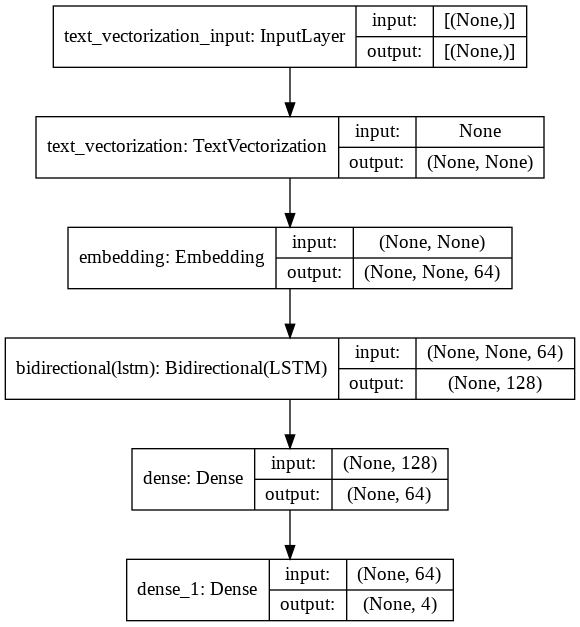

In [41]:
keras.utils.plot_model(model, "BiDirectionalLSTM.png", show_shapes=True)

##Create model by stacking two or more layers: Multi Layer Bidirectional RNN with LTSM (Experiment C2B)


Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

In [42]:
from keras import backend as K
K.clear_session()

model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [43]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [44]:
start=datetime.now()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end=datetime.now()
print("Experiment C2B time:", end-start) 

Epoch 1/200
1782/1782 [==============================] - 77s 34ms/step - loss: 0.5112 - accuracy: 0.8150 - val_loss: 0.4073 - val_accuracy: 0.8651
Epoch 2/200
1782/1782 [==============================] - 55s 31ms/step - loss: 0.4264 - accuracy: 0.8514 - val_loss: 0.3406 - val_accuracy: 0.8781
Epoch 3/200
1782/1782 [==============================] - 55s 31ms/step - loss: 0.4015 - accuracy: 0.8581 - val_loss: 0.4161 - val_accuracy: 0.8531
Epoch 4/200
1782/1782 [==============================] - 55s 31ms/step - loss: 0.3829 - accuracy: 0.8644 - val_loss: 0.3708 - val_accuracy: 0.8641
Experiment C2B time: 0:04:02.373360


In [45]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 13ms/step - loss: 0.3982 - accuracy: 0.8584
Test Loss: 0.3982197940349579
Test Accuracy: 0.8584210276603699


## Plotting Performance Metrics - Multi Layer Bidirectional RNN with LTSM (Experiment C2B)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [46]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [47]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.511,0.815,0.407,0.865
1,0.426,0.851,0.341,0.878
2,0.401,0.858,0.416,0.853
3,0.383,0.864,0.371,0.864


In [48]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

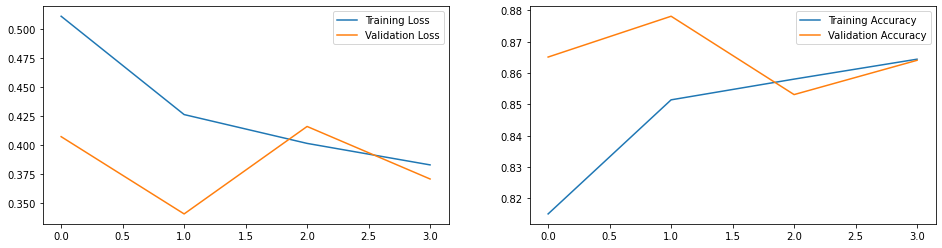

In [49]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [50]:
preds = model2.predict(test_dataset)

In [51]:
preds.shape

(7600, 4)

In [52]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [53]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.15%,99.88%,0.06%,0.67%,99.93%,0.34%,1.21%,11.82%,83.40%,0.19%,99.77%,0.68%,0.05%,79.76%,99.93%
Sports,99.85%,0.00%,0.03%,99.31%,0.00%,0.11%,98.63%,87.08%,0.51%,0.01%,0.00%,0.52%,0.00%,1.46%,0.00%
Business,0.00%,0.05%,3.69%,0.01%,0.04%,9.32%,0.07%,0.20%,4.42%,97.24%,0.10%,1.69%,99.87%,3.48%,0.04%
Sci/Tech,0.00%,0.07%,96.22%,0.01%,0.03%,90.23%,0.09%,0.91%,11.68%,2.56%,0.13%,97.11%,0.08%,15.30%,0.02%


#### Model Architecture Summary Multi Layer Bidirectional RNN with LTSM (Experiment C2B)

In [54]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2

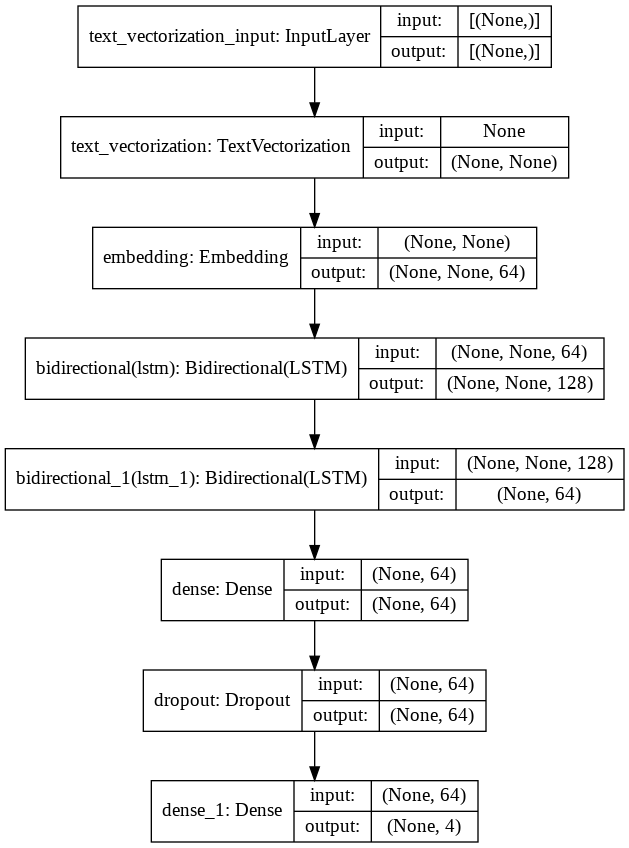

In [55]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).


## Create the model : Single Layer Bidirectional RNN GRU (Experiment C3B)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [56]:
from keras import backend as K
K.clear_session()

num_classes = 4
model3 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model: Single Layer Bidirectional RNN GRU (Experiment C3B)

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [57]:
model3.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [58]:
print([layer.supports_masking for layer in model3.layers])

[False, True, True, True, True]


## Train the model: Single Layer Bidirectional RNN GRU (Experiment C3B)

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [59]:
start=datetime.now()

history3 = model3.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end=datetime.now()
print("Experiment C3B time:", end-start) 

Epoch 1/200
1782/1782 [==============================] - 43s 19ms/step - loss: 0.7123 - accuracy: 0.7201 - val_loss: 0.4296 - val_accuracy: 0.8505
Epoch 2/200
1782/1782 [==============================] - 32s 18ms/step - loss: 0.4180 - accuracy: 0.8507 - val_loss: 0.4103 - val_accuracy: 0.8558
Epoch 3/200
1782/1782 [==============================] - 32s 18ms/step - loss: 0.3997 - accuracy: 0.8566 - val_loss: 0.3984 - val_accuracy: 0.8597
Epoch 4/200
1782/1782 [==============================] - 32s 18ms/step - loss: 0.3917 - accuracy: 0.8584 - val_loss: 0.3961 - val_accuracy: 0.8633
Epoch 5/200
1782/1782 [==============================] - 32s 18ms/step - loss: 0.3868 - accuracy: 0.8603 - val_loss: 0.3904 - val_accuracy: 0.8632
Epoch 6/200
1782/1782 [==============================] - 32s 18ms/step - loss: 0.3836 - accuracy: 0.8610 - val_loss: 0.3938 - val_accuracy: 0.8593
Experiment C3B time: 0:03:21.588314


In [60]:
test_loss, test_acc = model3.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 8ms/step - loss: 0.4083 - accuracy: 0.8529
Test Loss: 0.40829041600227356
Test Accuracy: 0.8528947234153748


## Plotting Performance Metrics: Single Layer Bidirectional RNN GRU (Experiment C3B)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [61]:
history_dict3 = history3.history
history_dict3.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [62]:
history3_df=pd.DataFrame(history_dict3)
history3_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.712,0.720,0.430,0.850
1,0.418,0.851,0.410,0.856
2,0.400,0.857,0.398,0.860
3,0.392,0.858,0.396,0.863
4,0.387,0.860,0.390,0.863
5,0.384,0.861,0.394,0.859


In [63]:
losses = history3.history['loss']
accs = history3.history['accuracy']
val_losses = history3.history['val_loss']
val_accs = history3.history['val_accuracy']
epochs = len(losses)

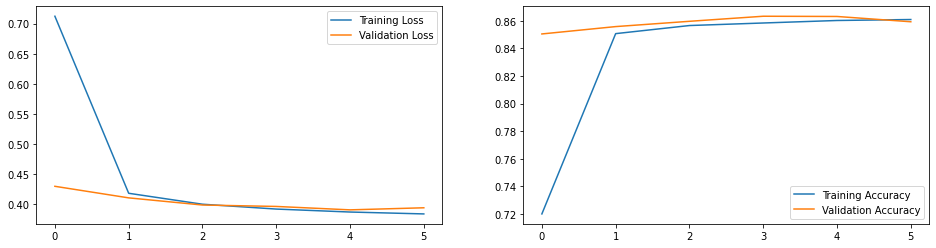

In [64]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Architecture Summary: Single Layer Bidirectional RNN GRU (Experiment C3B)

In [65]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49920     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 122,436
Trainable params: 122,436
Non-trainable params: 0
_________________________________________________________________


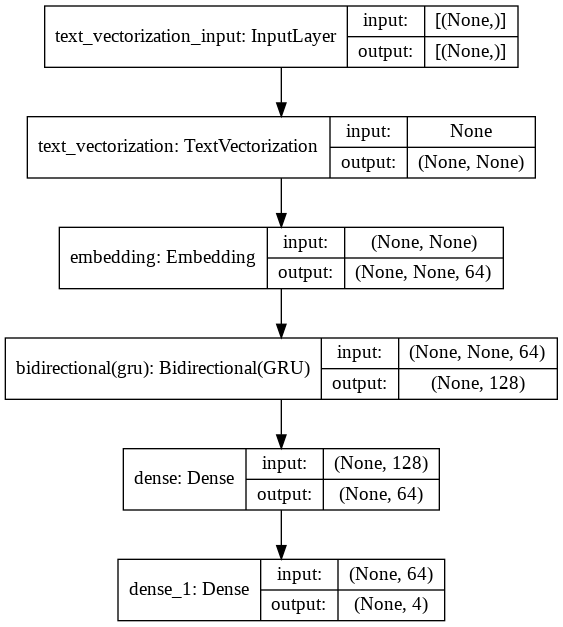

In [66]:
keras.utils.plot_model(model3, "BiDirectionalGRU.png", show_shapes=True)

##Create model: Multi Layer Bidirectional RNN with GRU (Experiment C4B)


Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/multilayerBidirectionalLSTM.png?raw=1">

In [67]:
from keras import backend as K
K.clear_session()

model4 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [68]:
model4.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [69]:
start=datetime.now()

history4 = model4.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end=datetime.now()
print("Experiment C4B time:", end-start) 

Epoch 1/200
1782/1782 [==============================] - 75s 33ms/step - loss: 0.5185 - accuracy: 0.8110 - val_loss: 0.3855 - val_accuracy: 0.8687
Epoch 2/200
1782/1782 [==============================] - 53s 30ms/step - loss: 0.4251 - accuracy: 0.8509 - val_loss: 0.4164 - val_accuracy: 0.8464
Epoch 3/200
1782/1782 [==============================] - 53s 29ms/step - loss: 0.4033 - accuracy: 0.8578 - val_loss: 0.3940 - val_accuracy: 0.8620
Experiment C4B time: 0:03:00.443453


In [70]:
test_loss, test_acc = model4.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 12ms/step - loss: 0.4045 - accuracy: 0.8533
Test Loss: 0.4045478403568268
Test Accuracy: 0.8532894849777222


## Plotting Performance Metrics: Multi Layer Bidirectional RNN with GRU (Experiment C4B)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [71]:
history_dict4 = history4.history
history_dict4.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [72]:
history4_df=pd.DataFrame(history_dict4)
history4_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.519,0.811,0.386,0.869
1,0.425,0.851,0.416,0.846
2,0.403,0.858,0.394,0.862


In [73]:
losses = history4.history['loss']
accs = history4.history['accuracy']
val_losses = history4.history['val_loss']
val_accs = history4.history['val_accuracy']
epochs = len(losses)

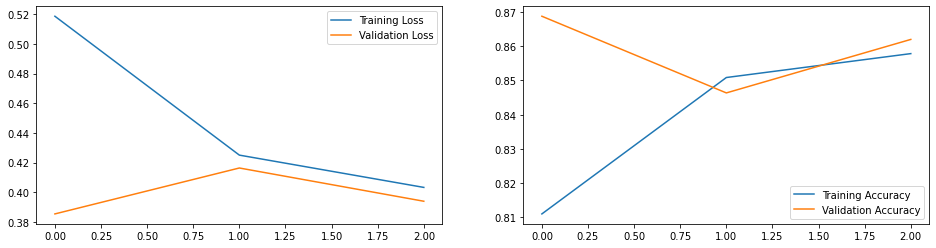

In [74]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [75]:
preds = model4.predict(test_dataset)

In [76]:
preds.shape

(7600, 4)

In [77]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [78]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.08%,99.79%,0.05%,0.66%,99.80%,0.33%,0.55%,8.05%,86.39%,2.03%,99.84%,0.12%,0.36%,74.82%,99.90%
Sports,99.88%,0.00%,0.00%,99.26%,0.01%,0.07%,99.32%,88.11%,0.98%,0.03%,0.01%,0.05%,0.00%,4.40%,0.00%
Business,0.03%,0.18%,4.31%,0.04%,0.14%,16.13%,0.05%,0.59%,3.21%,92.17%,0.14%,1.45%,99.11%,7.24%,0.09%
Sci/Tech,0.01%,0.03%,95.63%,0.04%,0.05%,83.47%,0.07%,3.25%,9.42%,5.76%,0.01%,98.38%,0.52%,13.53%,0.01%


#### Model Architecture Summary: Multi Layer Bidirectional RNN with GRU (Experiment C4B)

In [79]:
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49920     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                31104     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2

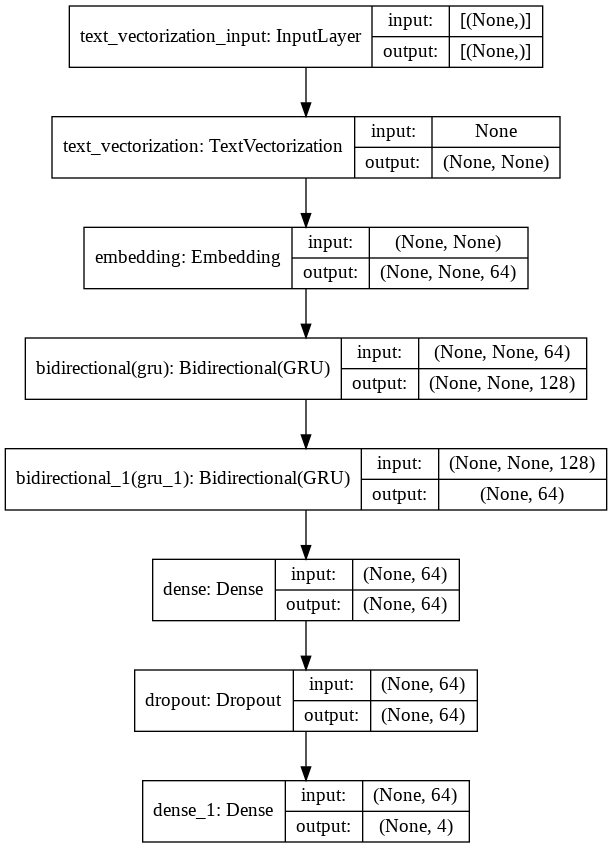

In [80]:
keras.utils.plot_model(model4, "2Layer_BiDirectionalGRU.png", show_shapes=True)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
